# Урок 5. Feature Engineering, Feature Selection, part I

Продолжим работу с данными, которые были использованы в ДЗ 2 и 3, продолжим решать задачу обнаружения мошеннических транзакций, что позволит получить полное решение задачи / полный пайплайн.

**Задание 0:** выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.

**Задание 1:** признак `TransactionDT` - это смещение в секундах относительно базовой даты. Базовая дата - `2017-12-01`, преобразовать признак `TransactionDT` в `datetime`, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

**Задание 2:** сделать конкатенацию признаков
* `card1 + card2`;
* `card1 + card2 + card_3 + card_5`;
* `card1 + card2 + card_3 + card_5 + addr1 + addr2`

Рассматривать их как категориальных признаки.

**Задание 3:** Сделать `FrequencyEncoder` для признаков `card1 - card6`, `addr1`, `addr2`.

**Задание 4:** Создать признаки на основе отношения: `TransactionAmt` к вычисленной статистике. Статистика - среднее значение / стандартное отклонение `TransactionAmt`, сгруппированное по `card1 - card6`, `addr1`, `addr2`, и по признакам, созданным в задании 2.

**Задание 5:** Создать признаки на основе отношения: D15 к вычисленной статистике. Статистика - среднее значение / стандартное отклонение D15, сгруппированное по `card1 - card6`, `addr1`, `addr2`, и по признакам, созданным в задании 2.

**Задание 6:** выделить дробную часть и целую часть признака `TransactionAmt` в два отдельных признака. После создать отдельных признак - логарифм от `TransactionAmt`

**Задание 7 (опция):** выполнить предварительную подготовку / очистку признаков `P_emaildomain` и `R_emaildomain` (что и как делать - остается на ваше усмотрение) и сделать Frequency Encoding для очищенных признаков.


In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import metrics
from datetime import timedelta
from datetime import datetime

from sklearn.model_selection import train_test_split
# from sunbird.categorical_encoding import frequency_encoding
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import scipy.stats as st

import warnings
warnings.simplefilter("ignore")

import warnings
from tqdm import tqdm
from typing import List, Tuple

from scipy.stats import ttest_rel

# from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
public_df = pd.read_csv('../assignment2_data/assignment_2_train.csv')
private_df = pd.read_csv('../assignment2_data/assignment_2_test.csv')

In [3]:
print("public_df.shape = {} rows, {} cols".format(*public_df.shape))
print("private_df.shape = {} rows, {} cols".format(*private_df.shape))

public_df.shape = 180000 rows, 394 cols
private_df.shape = 100001 rows, 394 cols


In [4]:
public_df.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
len(public_df['TransactionID'].value_counts())

180000

In [6]:
public_df[['TransactionID','isFraud','TransactionDT','TransactionAmt','addr1','addr2']]

,TransactionID,isFraud,TransactionDT,TransactionAmt,addr1,addr2
0,2987000,0,86400,68.50,315.0,87.0
1,2987001,0,86401,29.00,325.0,87.0
2,2987002,0,86469,59.00,330.0,87.0
3,2987003,0,86499,50.00,476.0,87.0
4,2987004,0,86506,50.00,420.0,87.0
...,...,...,...,...,...,...
179995,3166995,0,3958217,39.00,272.0,87.0
179996,3166996,0,3958237,59.95,315.0,87.0
179997,3166997,0,3958241,34.00,330.0,87.0
179998,3166998,0,3958260,59.00,272.0,87.0


## Задание 0:

In [12]:
# Получим список катероиальных и числовых признаков.

categorical = []
numerical = []
for col, value in public_df.iteritems():
    if value.dtype == 'object':
        categorical.append(col)
    else:
        numerical.append(col)

In [13]:
public_df[categorical].head(5)

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
 # Выделим числовые и категриальные переменные. 
public_df[categorical]=public_df[categorical].astype('category')


In [15]:
evalute_model_results = {
    'model_name': [],
    'Train-score': [],
    'Val-score': [],
    'Test-score': []
}

In [16]:
def evalute_model(df, categorical, model_name=""):

 # Разделим выборки на тренировчную, тестовую и валидационную.
    x_train, x_test = train_test_split(df.drop(["TransactionID", "isFraud"], axis=1), train_size=0.60, shuffle=False, random_state=1)
    y_train, y_test = train_test_split(df["isFraud"], train_size=0.60, shuffle=False, random_state=1,) # В данных имеется временная зависимость, поэтому пока перемешивать ничего не будем.

    x_test, x_val = train_test_split(x_test, train_size=0.50, shuffle=False, random_state=1,)
    y_test, y_val = train_test_split(y_test, train_size=0.50, shuffle=False, random_state=1,)



    params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "reg_lambda": 50,
    "max_depth": 4,
    'random_state':1    
    }

    model = lgb.LGBMClassifier(**params)

    model.fit(
        X=x_train,
        y=y_train,
        eval_set=[(x_val, y_val), (x_val, y_val)],
        early_stopping_rounds=50,
        categorical_feature=categorical,
      # num_boost_round=10000,
        eval_metric="auc",
        verbose=20
    )

    train_score =  roc_auc_score(y_train, model.predict(x_train))
    val_score = roc_auc_score(y_val, model.predict(x_val))
    test_score = roc_auc_score(y_test, model.predict(x_test))
   
    print(f"\r\n Train-score: {round(train_score, 3)}, Val-score: {round(val_score, 3)}, Test-score: {round(test_score, 3)}")
  
  # Заполним словарь c результатами обучения модели.
    evalute_model_results['model_name'].append(model_name)
    evalute_model_results['Train-score'].append(round(train_score, 3))
    evalute_model_results['Test-score'].append(round(test_score, 3))
    evalute_model_results['Val-score'].append(round(val_score, 3))


In [18]:
public_df.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
evalute_model(df=public_df, categorical=categorical, model_name='Задание_0')

[20]	valid_0's auc: 0.859651	valid_1's auc: 0.859651
[40]	valid_0's auc: 0.865949	valid_1's auc: 0.865949
[60]	valid_0's auc: 0.8706	valid_1's auc: 0.8706
[80]	valid_0's auc: 0.871479	valid_1's auc: 0.871479
[100]	valid_0's auc: 0.872493	valid_1's auc: 0.872493
[120]	valid_0's auc: 0.873055	valid_1's auc: 0.873055
[140]	valid_0's auc: 0.873847	valid_1's auc: 0.873847
[160]	valid_0's auc: 0.873269	valid_1's auc: 0.873269
[180]	valid_0's auc: 0.87396	valid_1's auc: 0.87396
[200]	valid_0's auc: 0.874522	valid_1's auc: 0.874522
[220]	valid_0's auc: 0.875116	valid_1's auc: 0.875116
[240]	valid_0's auc: 0.875126	valid_1's auc: 0.875126
[260]	valid_0's auc: 0.874849	valid_1's auc: 0.874849

 Train-score: 0.711, Val-score: 0.637, Test-score: 0.64


## Задание 1:

**Задание 1:** признак `TransactionDT` - это смещение в секундах относительно базовой даты. Базовая дата - `2017-12-01`, преобразовать признак `TransactionDT` в `datetime`, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

In [30]:
def data_time_converter(data):
    
    data['TransactionDT'] = data['TransactionDT'].apply(lambda x: datetime(2017, 12, 1) + timedelta(seconds=x))
    data['Transaction_weekday'] = data['TransactionDT'].apply(lambda x: x.weekday())
    data['Transaction_year'] = data['TransactionDT'].apply(lambda x: x.date().year)
    data['Transaction_mounth'] = data['TransactionDT'].apply(lambda x: x.date().month)
    data['Transaction_day'] = data['TransactionDT'].apply(lambda x: x.date().day)
    data['Transaction_hour'] = data['TransactionDT'].apply(lambda x: x.time().hour)
    # return data

In [31]:
data_time_converter(public_df)

In [32]:
public_df = public_df.drop(["TransactionDT"], axis=1)

In [33]:
public_df

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V335,V336,V337,V338,V339,Transaction_weekday,Transaction_year,Transaction_mounth,Transaction_day,Transaction_hour
0,2987000,0,68.50,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,5,2017,12,2,0
1,2987001,0,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,5,2017,12,2,0
2,2987002,0,59.00,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,5,2017,12,2,0
3,2987003,0,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,5,2017,12,2,0
4,2987004,0,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,5,2017,12,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3166995,0,39.00,W,1877,310.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,0,2018,1,15,19
179996,3166996,0,59.95,W,10075,514.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,0,2018,1,15,19
179997,3166997,0,34.00,W,6053,122.0,150.0,mastercard,195.0,debit,...,NaN,NaN,NaN,NaN,NaN,0,2018,1,15,19
179998,3166998,0,59.00,W,7726,555.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,0,2018,1,15,19


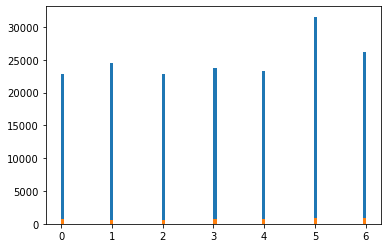

In [34]:
# Здесь лучше всего сделать два графика!

plt.hist(public_df.loc[(public_df['isFraud']==0,'Transaction_weekday')], 100)

plt.hist(public_df.loc[(public_df['isFraud']==1,'Transaction_weekday')], 100)
# plt.hist(train_df.loc[((train_df['isFraud']==1) &  (train_df['TransactionDT'][:10000]),'TransactionDT')], 100)
plt.show()

In [35]:
public_df.loc[(public_df['isFraud']==0,'Transaction_weekday')].value_counts()

5    31567
6    26200
1    24456
3    23764
4    23219
0    22867
2    22786
Name: Transaction_weekday, dtype: int64

In [36]:
public_df.loc[(public_df['isFraud']==1,'Transaction_weekday')].value_counts()

5    919
6    821
4    733
0    699
3    696
2    643
1    630
Name: Transaction_weekday, dtype: int64

In [37]:
evalute_model(df=public_df, categorical=categorical, model_name='Задание_1')

[20]	valid_0's auc: 0.864817	valid_1's auc: 0.864817
[40]	valid_0's auc: 0.872363	valid_1's auc: 0.872363
[60]	valid_0's auc: 0.877093	valid_1's auc: 0.877093
[80]	valid_0's auc: 0.879152	valid_1's auc: 0.879152
[100]	valid_0's auc: 0.880353	valid_1's auc: 0.880353
[120]	valid_0's auc: 0.882405	valid_1's auc: 0.882405
[140]	valid_0's auc: 0.883473	valid_1's auc: 0.883473
[160]	valid_0's auc: 0.884547	valid_1's auc: 0.884547
[180]	valid_0's auc: 0.88565	valid_1's auc: 0.88565
[200]	valid_0's auc: 0.885804	valid_1's auc: 0.885804
[220]	valid_0's auc: 0.88554	valid_1's auc: 0.88554
[240]	valid_0's auc: 0.886356	valid_1's auc: 0.886356
[260]	valid_0's auc: 0.88729	valid_1's auc: 0.88729
[280]	valid_0's auc: 0.887843	valid_1's auc: 0.887843
[300]	valid_0's auc: 0.888353	valid_1's auc: 0.888353
[320]	valid_0's auc: 0.888822	valid_1's auc: 0.888822
[340]	valid_0's auc: 0.888968	valid_1's auc: 0.888968
[360]	valid_0's auc: 0.888933	valid_1's auc: 0.888933
[380]	valid_0's auc: 0.889041	valid_1'

## Задание 2

 сделать конкатенацию признаков
 * `card1 + card2`;
 * `card1 + card2 + card_3 + card_5`;
 * `card1 + card2 + card_3 + card_5 + addr1 + addr2`

 Рассматривать их как категориальных признаки.

In [39]:
public_df[['card1','card2', 'card3','card5', 'addr1','addr2']]

,card1,card2,card3,card5,addr1,addr2
0,13926,NaN,150.0,142.0,315.0,87.0
1,2755,404.0,150.0,102.0,325.0,87.0
2,4663,490.0,150.0,166.0,330.0,87.0
3,18132,567.0,150.0,117.0,476.0,87.0
4,4497,514.0,150.0,102.0,420.0,87.0
...,...,...,...,...,...,...
179995,1877,310.0,150.0,224.0,272.0,87.0
179996,10075,514.0,150.0,224.0,315.0,87.0
179997,6053,122.0,150.0,195.0,330.0,87.0
179998,7726,555.0,150.0,226.0,272.0,87.0


In [40]:
def feature_concatinate(data):
    data.loc[(data['card1'].isna()),'card1'] = 0  
    data.loc[(data['card2'].isna()),'card2'] = 0  
    data.loc[(data['card3'].isna()),'card3'] = 0  
    data.loc[(data['card5'].isna()),'card5'] = 0  
    data.loc[(data['addr1'].isna()),'addr1'] = 0  
    data.loc[(data['addr2'].isna()),'addr2'] = 0  
    data['card1_2'] = data['card1']+data['card2']
    data['card1_5'] = data['card1']+data['card2']+data['card3']+data['card5']
    data['card1_ad2'] = data['card1']+data['card2']+data['card3']+data['card5']+data['addr1']+data['addr2']
    data[['card1_2','card1_5','card1_ad2']]=data[['card1_2','card1_5','card1_ad2']].astype('category')

In [41]:
feature_concatinate(public_df)

In [45]:
public_df[['card1_2','card1_5','card1_ad2']]

,card1_2,card1_5,card1_ad2
0,13926.0,14218.0,14620.0
1,3159.0,3411.0,3823.0
2,5153.0,5469.0,5886.0
3,18699.0,18966.0,19529.0
4,5011.0,5263.0,5770.0
...,...,...,...
179995,2187.0,2561.0,2920.0
179996,10589.0,10963.0,11365.0
179997,6175.0,6520.0,6937.0
179998,8281.0,8657.0,9016.0


In [46]:
evalute_model(df=public_df, categorical=categorical, model_name='Задание_2')

[20]	valid_0's auc: 0.859883	valid_1's auc: 0.859883
[40]	valid_0's auc: 0.870211	valid_1's auc: 0.870211
[60]	valid_0's auc: 0.875464	valid_1's auc: 0.875464
[80]	valid_0's auc: 0.878177	valid_1's auc: 0.878177
[100]	valid_0's auc: 0.879211	valid_1's auc: 0.879211
[120]	valid_0's auc: 0.880176	valid_1's auc: 0.880176
[140]	valid_0's auc: 0.879792	valid_1's auc: 0.879792

 Train-score: 0.68, Val-score: 0.652, Test-score: 0.636


## Задание 3

Сделать `FrequencyEncoder` для признаков `card1 - card6`, `addr1`, `addr2`.

In [48]:
def get_freq_encoder(data,feature_names):
    for feature_name in feature_names:
        freq_encoder = data[feature_name].value_counts(normalize=True)
        data[f"{feature_name}_freq_enc"] = data[feature_name].map(freq_encoder)
    return data

In [49]:
feature_names = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2']

public_df = get_freq_encoder(public_df, feature_names)

In [50]:
evalute_model(df=public_df, categorical=categorical, model_name='Задание_3')

[20]	valid_0's auc: 0.864322	valid_1's auc: 0.864322
[40]	valid_0's auc: 0.872582	valid_1's auc: 0.872582
[60]	valid_0's auc: 0.87676	valid_1's auc: 0.87676
[80]	valid_0's auc: 0.880948	valid_1's auc: 0.880948
[100]	valid_0's auc: 0.882211	valid_1's auc: 0.882211
[120]	valid_0's auc: 0.882614	valid_1's auc: 0.882614
[140]	valid_0's auc: 0.883893	valid_1's auc: 0.883893
[160]	valid_0's auc: 0.884583	valid_1's auc: 0.884583
[180]	valid_0's auc: 0.885471	valid_1's auc: 0.885471
[200]	valid_0's auc: 0.886041	valid_1's auc: 0.886041
[220]	valid_0's auc: 0.886161	valid_1's auc: 0.886161
[240]	valid_0's auc: 0.886751	valid_1's auc: 0.886751
[260]	valid_0's auc: 0.886403	valid_1's auc: 0.886403
[280]	valid_0's auc: 0.888019	valid_1's auc: 0.888019
[300]	valid_0's auc: 0.888201	valid_1's auc: 0.888201
[320]	valid_0's auc: 0.8884	valid_1's auc: 0.8884
[340]	valid_0's auc: 0.889128	valid_1's auc: 0.889128
[360]	valid_0's auc: 0.889669	valid_1's auc: 0.889669
[380]	valid_0's auc: 0.890179	valid_1'

## Задание 4

Создать признаки на основе отношения: `TransactionAmt` к вычисленной статистике. Статистика - среднее значение / стандартное отклонение `TransactionAmt`, сгруппированное по `card1 - card6`, `addr1`, `addr2`, и по признакам, созданным в задании 2.

In [ ]:
public_df['TransactionAmt'].describe()

count    180000.000000
mean        129.514237
std         206.515032
min           0.292000
25%          44.000000
50%          75.000000
75%         125.000000
max        5278.950000
Name: TransactionAmt, dtype: float64

In [51]:
feature_names = ['card1_2','card1_5','card1_ad2', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2']

In [52]:
def create_aggs(data, feature, agg_names):
    for agg_name in agg_names:
        stat = data.groupby(agg_name, as_index=False)
        stat_feature_mean = stat[feature].mean()
        stat_feature_std = stat[feature].std()

        stat_feature_std = stat_feature_std.rename(columns={feature: f'{feature}_{agg_name}_std'})
        stat_feature_mean = stat_feature_mean.rename(columns={feature: f'{feature}_{agg_name}_mean'})
    
        data = data.merge(stat_feature_std, how='left', on=agg_name)
        data = data.merge(stat_feature_mean, how='left', on=agg_name)

In [53]:
create_aggs(public_df, 'TransactionAmt', feature_names)  # Эту ф-ю нужно разделить для числовых и категориальных.

In [54]:
public_df.head(3)

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,card1_5,card1_ad2,card1_freq_enc,card2_freq_enc,card3_freq_enc,card4_freq_enc,card5_freq_enc,card6_freq_enc,addr1_freq_enc,addr2_freq_enc
0,2987000,0,68.5,W,13926,0.0,150.0,discover,142.0,credit,...,14218.0,14620.0,0.000061,0.014506,0.879722,0.013212,0.000272,0.317951,0.038156,0.876289
1,2987001,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,3411.0,3823.0,0.001244,0.006756,0.879722,0.302797,0.054433,0.317951,0.071367,0.876289
2,2987002,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,5469.0,5886.0,0.001428,0.060522,0.879722,0.657224,0.079844,0.681949,0.041217,0.876289


In [55]:
evalute_model(df=public_df, categorical=categorical, model_name='Задание_4')

[20]	valid_0's auc: 0.864322	valid_1's auc: 0.864322
[40]	valid_0's auc: 0.872582	valid_1's auc: 0.872582
[60]	valid_0's auc: 0.87676	valid_1's auc: 0.87676
[80]	valid_0's auc: 0.880948	valid_1's auc: 0.880948
[100]	valid_0's auc: 0.882211	valid_1's auc: 0.882211
[120]	valid_0's auc: 0.882614	valid_1's auc: 0.882614
[140]	valid_0's auc: 0.883893	valid_1's auc: 0.883893
[160]	valid_0's auc: 0.884583	valid_1's auc: 0.884583
[180]	valid_0's auc: 0.885471	valid_1's auc: 0.885471
[200]	valid_0's auc: 0.886041	valid_1's auc: 0.886041
[220]	valid_0's auc: 0.886161	valid_1's auc: 0.886161
[240]	valid_0's auc: 0.886751	valid_1's auc: 0.886751
[260]	valid_0's auc: 0.886403	valid_1's auc: 0.886403
[280]	valid_0's auc: 0.888019	valid_1's auc: 0.888019
[300]	valid_0's auc: 0.888201	valid_1's auc: 0.888201
[320]	valid_0's auc: 0.8884	valid_1's auc: 0.8884
[340]	valid_0's auc: 0.889128	valid_1's auc: 0.889128
[360]	valid_0's auc: 0.889669	valid_1's auc: 0.889669
[380]	valid_0's auc: 0.890179	valid_1'

## Задание 5 

Создать признаки на основе отношения: D15 к вычисленной статистике. Статистика - среднее значение / стандартное отклонение D15, сгруппированное по `card1 - card6`, `addr1`, `addr2`, и по признакам, созданным в задании 2.


In [56]:
create_aggs(public_df, 'D15', feature_names)  # Эту ф-ю нужно разделить для числовых и категориальных.

In [57]:
public_df.head()

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,card1_5,card1_ad2,card1_freq_enc,card2_freq_enc,card3_freq_enc,card4_freq_enc,card5_freq_enc,card6_freq_enc,addr1_freq_enc,addr2_freq_enc
0,2987000,0,68.5,W,13926,0.0,150.0,discover,142.0,credit,...,14218.0,14620.0,0.000061,0.014506,0.879722,0.013212,0.000272,0.317951,0.038156,0.876289
1,2987001,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,3411.0,3823.0,0.001244,0.006756,0.879722,0.302797,0.054433,0.317951,0.071367,0.876289
2,2987002,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,5469.0,5886.0,0.001428,0.060522,0.879722,0.657224,0.079844,0.681949,0.041217,0.876289
3,2987003,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,18966.0,19529.0,0.006600,0.009867,0.879722,0.302797,0.037106,0.681949,0.015411,0.876289
4,2987004,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,5263.0,5770.0,0.000011,0.030389,0.879722,0.302797,0.054433,0.317951,0.006967,0.876289


In [58]:
evalute_model(df=public_df, categorical=categorical, model_name='Задание_5')

[20]	valid_0's auc: 0.864322	valid_1's auc: 0.864322
[40]	valid_0's auc: 0.872582	valid_1's auc: 0.872582
[60]	valid_0's auc: 0.87676	valid_1's auc: 0.87676
[80]	valid_0's auc: 0.880948	valid_1's auc: 0.880948
[100]	valid_0's auc: 0.882211	valid_1's auc: 0.882211
[120]	valid_0's auc: 0.882614	valid_1's auc: 0.882614
[140]	valid_0's auc: 0.883893	valid_1's auc: 0.883893
[160]	valid_0's auc: 0.884583	valid_1's auc: 0.884583
[180]	valid_0's auc: 0.885471	valid_1's auc: 0.885471
[200]	valid_0's auc: 0.886041	valid_1's auc: 0.886041
[220]	valid_0's auc: 0.886161	valid_1's auc: 0.886161
[240]	valid_0's auc: 0.886751	valid_1's auc: 0.886751
[260]	valid_0's auc: 0.886403	valid_1's auc: 0.886403
[280]	valid_0's auc: 0.888019	valid_1's auc: 0.888019
[300]	valid_0's auc: 0.888201	valid_1's auc: 0.888201
[320]	valid_0's auc: 0.8884	valid_1's auc: 0.8884
[340]	valid_0's auc: 0.889128	valid_1's auc: 0.889128
[360]	valid_0's auc: 0.889669	valid_1's auc: 0.889669
[380]	valid_0's auc: 0.890179	valid_1'

## Задание 6

Выделить дробную часть и целую часть признака `TransactionAmt` в два отдельных признака. После создать отдельных признак - логарифм от `TransactionAmt`


In [59]:
public_df['TransactionAmt_d'], public_df['TransactionAmt_c'] = np.modf(public_df['TransactionAmt'])

In [60]:
public_df['TransactionAmt_log'] = np.log(public_df['TransactionAmt'])

In [61]:
evalute_model(df=public_df, categorical=categorical, model_name='Задание_6')

[20]	valid_0's auc: 0.864291	valid_1's auc: 0.864291
[40]	valid_0's auc: 0.873693	valid_1's auc: 0.873693
[60]	valid_0's auc: 0.876746	valid_1's auc: 0.876746
[80]	valid_0's auc: 0.88107	valid_1's auc: 0.88107
[100]	valid_0's auc: 0.883374	valid_1's auc: 0.883374
[120]	valid_0's auc: 0.884476	valid_1's auc: 0.884476
[140]	valid_0's auc: 0.885366	valid_1's auc: 0.885366
[160]	valid_0's auc: 0.886771	valid_1's auc: 0.886771
[180]	valid_0's auc: 0.887281	valid_1's auc: 0.887281
[200]	valid_0's auc: 0.887965	valid_1's auc: 0.887965
[220]	valid_0's auc: 0.888329	valid_1's auc: 0.888329
[240]	valid_0's auc: 0.88881	valid_1's auc: 0.88881
[260]	valid_0's auc: 0.889252	valid_1's auc: 0.889252
[280]	valid_0's auc: 0.888896	valid_1's auc: 0.888896
[300]	valid_0's auc: 0.889687	valid_1's auc: 0.889687
[320]	valid_0's auc: 0.890433	valid_1's auc: 0.890433
[340]	valid_0's auc: 0.891977	valid_1's auc: 0.891977
[360]	valid_0's auc: 0.892114	valid_1's auc: 0.892114
[380]	valid_0's auc: 0.892844	valid_

## Задание 7 (опция)

Выполнить предварительную подготовку / очистку признаков `P_emaildomain` и `R_emaildomain` (что и как делать - остается на ваше усмотрение) и сделать Frequency Encoding для очищенных признаков.


### Сводная таблица. 

In [62]:
pd.DataFrame(evalute_model_results)

,model_name,Train-score,Val-score,Test-score
0,Задание_0,0.711,0.637,0.640
1,Задание_1,0.749,0.671,0.663
2,Задание_2,0.680,0.652,0.636
3,Задание_3,0.763,0.675,0.664
4,Задание_4,0.763,0.675,0.664
5,Задание_5,0.763,0.675,0.664
6,Задание_6,0.765,0.674,0.666
